<a href="https://colab.research.google.com/github/ashishkej/eva8_session9/blob/main/EVA8_Session9_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA8 Sesson9 Assignment Colab Notebook
## Buid basic Transformer ULTIMUS network

# Installing required Libraries

In [1]:
!pip install grad-cam
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=d96cdd20bc7114e837d215f1e40ca4bf53676536c4e71c34beda4c2bc7ef1813
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Cloning Main repo containing models, training code and utils functions

In [2]:
!git clone https://github.com/ashishkej/eva8-pytorch-models

Cloning into 'eva8-pytorch-models'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 130 (delta 69), reused 96 (delta 38), pack-reused 0
Receiving objects: 100% (130/130), 22.23 KiB | 1.06 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [3]:
import sys 
sys.path.append('/content/eva8-pytorch-models')

In [4]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [5]:
from torchsummary import summary
from models import model9_transformers
net = model9_transformers.Vit().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
       BatchNorm2d-2           [-1, 16, 30, 30]              32
              ReLU-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           4,608
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7             [-1, 32, 7, 7]               0
            Conv2d-8             [-1, 48, 5, 5]          13,824
       BatchNorm2d-9             [-1, 48, 5, 5]              96
             ReLU-10             [-1, 48, 5, 5]               0
        AvgPool2d-11             [-1, 48, 1, 1]               0
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

In [6]:
import main
import utils

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


In [8]:
import torchvision
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(utils.AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(utils.AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
import copy
import torch.nn.functional as F
from torch_lr_finder import LRFinder

# Finding Learning rate using LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-02


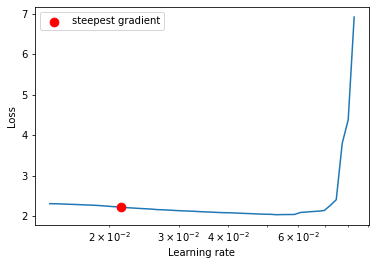

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.021461411978584043)

In [14]:
net = model9_transformers.Vit().to(device)
net1_exp = copy.deepcopy(net)
optimizer = torch.optim.Adam(net1_exp.parameters(), lr=0.01)
criterion = F.nll_loss
lr_finder = LRFinder(net1_exp, optimizer, criterion, device=device)
lr_finder.range_test(test_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [15]:
import numpy as np
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.052919787359584414


#Training using OCP

In [17]:
net = model9_transformers.Vit().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                ) #final_div_factor=100,

net, history = main.fit_model(net, device, train_loader, test_loader,optimizer, scheduler,NUM_EPOCHS=24)

EPOCH: 1 (LR: 0.005291978735958443)


Batch_id=97 Loss=1.95415 Accuracy=19.91: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 1.9046, Accuracy: 2286/10000 (22.86%)

EPOCH: 2 (LR: 0.010233274457450266)


Batch_id=97 Loss=1.84020 Accuracy=24.80: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]



Test set: Average loss: 1.8906, Accuracy: 2354/10000 (23.54%)

EPOCH: 3 (LR: 0.023006561007466925)


Batch_id=97 Loss=2.48386 Accuracy=23.03: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 1739.1529, Accuracy: 1000/10000 (10.00%)

EPOCH: 4 (LR: 0.038311020397277615)


Batch_id=97 Loss=23150.98366 Accuracy=10.21: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]



Test set: Average loss: 979368.0400, Accuracy: 1000/10000 (10.00%)

EPOCH: 5 (LR: 0.04979541691916989)


Batch_id=97 Loss=234963.67970 Accuracy=9.91: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 167265.9756, Accuracy: 1000/10000 (10.00%)

EPOCH: 6 (LR: 0.0529041693601187)


Batch_id=97 Loss=2691878.30059 Accuracy=10.24: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 8499240.5760, Accuracy: 1000/10000 (10.00%)

EPOCH: 7 (LR: 0.05240374711061022)


Batch_id=97 Loss=3442674.23585 Accuracy=10.03: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]



Test set: Average loss: 6731.9682, Accuracy: 1000/10000 (10.00%)

EPOCH: 8 (LR: 0.051211691655725526)


Batch_id=97 Loss=5638.31247 Accuracy=10.03: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 348.8569, Accuracy: 1000/10000 (10.00%)

EPOCH: 9 (LR: 0.04935984677315922)


Batch_id=97 Loss=317.52115 Accuracy=10.04: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]



Test set: Average loss: 465.1644, Accuracy: 1000/10000 (10.00%)

EPOCH: 10 (LR: 0.04689768141716482)


Batch_id=97 Loss=194.61634 Accuracy=9.91: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 93.1192, Accuracy: 1000/10000 (10.00%)

EPOCH: 11 (LR: 0.04389096823776659)


Batch_id=97 Loss=92.90247 Accuracy=9.93: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s]



Test set: Average loss: 62.7351, Accuracy: 1000/10000 (10.00%)

EPOCH: 12 (LR: 0.04042002657387099)


Batch_id=97 Loss=854.62883 Accuracy=9.78: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]



Test set: Average loss: 292.4805, Accuracy: 1000/10000 (10.00%)

EPOCH: 13 (LR: 0.03657757685579286)


Batch_id=97 Loss=503.35494 Accuracy=9.74: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]



Test set: Average loss: 427.2730, Accuracy: 1000/10000 (10.00%)

EPOCH: 14 (LR: 0.032466263733262044)


Batch_id=97 Loss=78504.17949 Accuracy=10.06: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 1922874.3104, Accuracy: 1000/10000 (10.00%)

EPOCH: 15 (LR: 0.028195914094423975)


Batch_id=97 Loss=8256063.38249 Accuracy=9.74: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 376931.4776, Accuracy: 1000/10000 (10.00%)

EPOCH: 16 (LR: 0.023880603223293495)


Batch_id=97 Loss=67968.61411 Accuracy=10.04: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 16044.0472, Accuracy: 1000/10000 (10.00%)

EPOCH: 17 (LR: 0.019635607468383002)


Batch_id=97 Loss=67290.06529 Accuracy=9.88: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 60626.5602, Accuracy: 1000/10000 (10.00%)

EPOCH: 18 (LR: 0.015574324826891384)


Batch_id=97 Loss=38092.95109 Accuracy=10.13: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 32249.9162, Accuracy: 1000/10000 (10.00%)

EPOCH: 19 (LR: 0.011805245705922316)


Batch_id=97 Loss=24317.67822 Accuracy=10.13: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 10885.2448, Accuracy: 1000/10000 (10.00%)

EPOCH: 20 (LR: 0.00842905478180502)


Batch_id=97 Loss=10332.77406 Accuracy=9.96: 100%|██████████| 98/98 [00:15<00:00,  6.35it/s]



Test set: Average loss: 6101.9909, Accuracy: 1000/10000 (10.00%)

EPOCH: 21 (LR: 0.005535941376522454)


Batch_id=97 Loss=5509.31861 Accuracy=9.85: 100%|██████████| 98/98 [00:14<00:00,  6.53it/s]



Test set: Average loss: 5619.1156, Accuracy: 1000/10000 (10.00%)

EPOCH: 22 (LR: 0.0032031902000648907)


Batch_id=97 Loss=3309.47413 Accuracy=9.72: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 2266.6987, Accuracy: 1000/10000 (10.00%)

EPOCH: 23 (LR: 0.0014931168180174388)


Batch_id=97 Loss=1771.18311 Accuracy=9.78: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 1226.1753, Accuracy: 1000/10000 (10.00%)

EPOCH: 24 (LR: 0.00045140299492910205)


Batch_id=97 Loss=598.80415 Accuracy=10.08: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 132.6327, Accuracy: 1000/10000 (10.00%)



# Learning Rate plot during 24 epochs

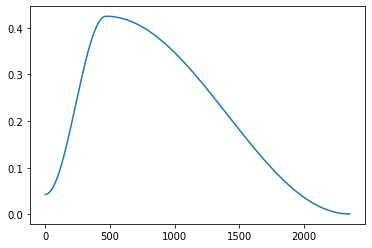

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history[4])